In [1]:
import os
import glob
import ntpath
import pydicom
import nibabel as nib
import numpy as np
from pydicom.fileset import FileSet
from tqdm.notebook import tqdm
import shutil

# Define source and destination directories
src_images_dir = r'D:\CTH_archive\CTH_STRIPPED'
src_labels_dir = r'D:\CTH_archive\TMAX_NIFTI\Reg_Quant>'
dst_dir = r'D:\nnUNet_raw\Dataset037_Perfusion'

# Create destination directories if they don't exist
os.makedirs(os.path.join(dst_dir, 'imagesTr'), exist_ok=True)
os.makedirs(os.path.join(dst_dir, 'imagesTs'), exist_ok=True)
os.makedirs(os.path.join(dst_dir, 'labelsTr'), exist_ok=True)

# Delete all files in destination directories
for dir_path in [os.path.join(dst_dir, 'imagesTr'), os.path.join(dst_dir, 'imagesTs'), os.path.join(dst_dir, 'labelsTr')]:
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)

# Function to convert file path to nnUNet format
def convert_to_nnunet_format(file_path):
    filename = ntpath.basename(file_path).split('.')[0]
    return filename

# Function to convert DICOM to NIfTI
def dicom_to_nifti(dicom_dir, nifti_file):
    # Load the DICOM files
    files = []
    for fname in glob.glob(os.path.join(dicom_dir, '**', '*.dcm'), recursive=True):
        files.append(pydicom.dcmread(fname))

    # Skip if no DICOM files found
    if not files:
        return

    # Ensure they're in the correct order
    files.sort(key=lambda x: int(x.InstanceNumber))

    # Get image data
    image_data = np.stack([s.pixel_array for s in files])

    # Get metadata from the first file
    ref_file = files[0]

    # Create affine transformation
    pixel_spacing = np.array(ref_file.PixelSpacing)
    slice_thickness = np.array(ref_file.SliceThickness)
    affine = np.eye(4)
    affine[0, 0] = pixel_spacing[0]
    affine[1, 1] = pixel_spacing[1]
    affine[2, 2] = slice_thickness

    # Create NIfTI image
    nifti_img = nib.Nifti1Image(image_data, affine)

    # Save NIfTI image
    nib.save(nifti_img, nifti_file)

# Get list of label files
label_files = glob.glob(os.path.join(src_labels_dir, '*.nii'))

# Convert and copy images
for patient_id, patient_dir in tqdm(enumerate(glob.glob(os.path.join(src_images_dir, '*'))), desc='Converting images', unit='patient', total=len(glob.glob(os.path.join(src_images_dir, '*')))):
    new_filename = convert_to_nnunet_format(patient_dir)
    # Check if corresponding label exists
    corresponding_label = os.path.join(src_labels_dir, new_filename)
    if corresponding_label not in label_files:
        continue
    nifti_file = os.path.join(dst_dir, 'imagesTr', new_filename + '.nii.gz')
    dicom_to_nifti(patient_dir, nifti_file)

# Copy labels
for patient_id, label_file in tqdm(enumerate(label_files), desc='Copying labels', unit='label', total=len(label_files)):
    new_filename = convert_to_nnunet_format(label_file)
    # Load the original label file
    label_data = nib.load(label_file)
    # Save the label file in gzip format
    nib.save(label_data, os.path.join(dst_dir, 'labelsTr', new_filename + '.nii.gz'))

# Move the last three scans from '/imagesTr' to '/imagesTs' and remove the corresponding labels from '/labelsTr'
image_files_tr = sorted(glob.glob(os.path.join(dst_dir, 'imagesTr', '*.nii.gz')))
label_files_tr = sorted(glob.glob(os.path.join(dst_dir, 'labelsTr', '*.nii.gz')))

for i in range(-3, 0, 1):
    shutil.move(image_files_tr[i], os.path.join(dst_dir, 'imagesTs', ntpath.basename(image_files_tr[i])))
    os.remove(label_files_tr[i])

Converting images:   0%|          | 0/107 [00:00<?, ?patient/s]

Copying labels: 0label [00:00, ?label/s]

IndexError: list index out of range

In [30]:
import json

# Define the dataset
dataset = {
    "labels": {
        "background": "0",
        "quantized_1": "51",
        "quantized_2": "10",
        "quantized_3": "153",
        "quantized_4": "204",
        "quantized_5": "255"
    },
    "numTraining": 91,
    "numTest": 0,
    "channel_names": {
        "0": "CT"
    },
    "file_ending": ".nii.gz",
    "training": [],
    "test": []
}


# Write the dataset to the dataset.json file
with open(r'D:\nnUNet_raw\Dataset037_Perfusion\dataset.json', 'w') as f:
    json.dump(dataset, f, indent=4)

In [104]:
import os
import glob

# Get all image files
image_files = glob.glob(r'D:\nnUNet_raw\Dataset037_Perfusion\labelsTr\*.nii.gz')

# Sort the files to ensure consistent ordering
image_files.sort()

# Rename all image files
for i, image_file in enumerate(image_files, start=1):
    # Create the new filename
    new_filename = f'perfusion_{i:03}.nii.gz'
    # Rename the file
    os.rename(image_file, os.path.join(os.path.dirname(image_file), new_filename))

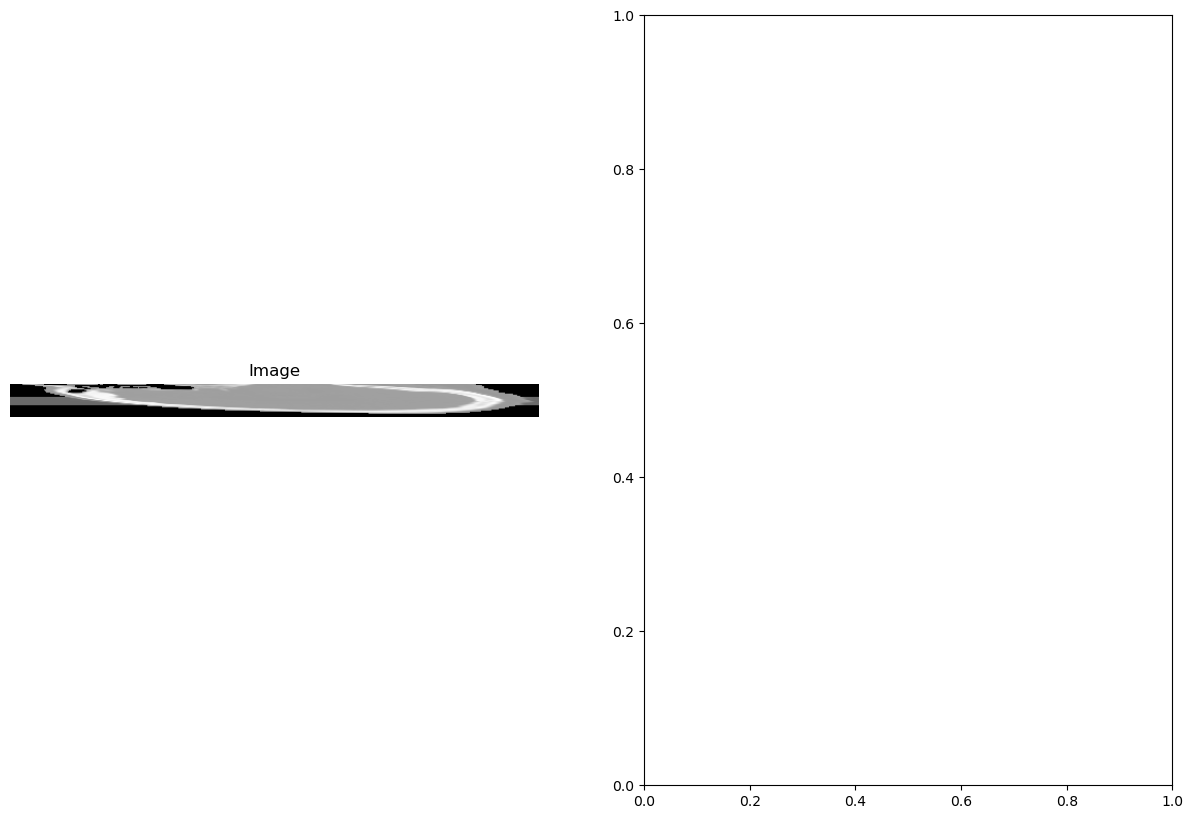

interactive(children=(IntSlider(value=255, description='Slice Index', max=511), Output()), _dom_classes=('widg…

<function __main__.plot_slices(slice_idx)>

In [3]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import nibabel as nib

# Load the image and label data
image_data = nib.load(r'D:\nnUNet_raw\Dataset037_Perfusion\imagesTr\perfusion_001_0000.nii.gz').get_fdata()
label_data = nib.load(r'D:\nnUNet_raw\Dataset037_Perfusion\imagesTr\segmentation\brain.nii.gz').get_fdata()

def plot_slices(slice_idx):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    # Display the image slice
    axes[0].imshow(image_data[:, :, slice_idx], cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Display the label slice
    axes[1].imshow(label_data[slice_idx, :, :], cmap='gray')
    axes[1].set_title('Label')
    axes[1].axis('off')

    plt.show()

# Create an interactive slider to scroll through slices
max_slices = min(image_data.shape[2], label_data.shape[2]) - 1
interact(plot_slices, slice_idx=IntSlider(min=0, max=max_slices, step=1, value=max_slices // 2, description='Slice Index'))

In [17]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import nibabel as nib

# Load the segmentation mask
seg_data = nib.load(r'D:\nnUNet_raw\Dataset037_Perfusion\imagesTr\segmentation\brain.nii.gz').get_fdata()

def plot_slices(slice_idx):
    fig, axes = plt.subplots(figsize=(15, 10))
    
    # Display the segmentation mask slice
    axes.imshow(seg_data[slice_idx, :, :], cmap='gray')
    axes.set_title('Segmentation Mask')
    axes.axis('off')

    plt.show()

# Create an interactive slider to scroll through slices
max_slices = seg_data.shape[0] - 1
interact(plot_slices, slice_idx=IntSlider(min=0, max=max_slices, step=1, value=max_slices // 2, description='Slice Index'))

interactive(children=(IntSlider(value=15, description='Slice Index', max=31), Output()), _dom_classes=('widget…

<function __main__.plot_slices(slice_idx)>

In [20]:
import os

# Define the source directory
source_dir = r'D:\nnUNet_raw\Dataset037_Perfusion\labelsTr'

# List all files in the source directory
files = os.listdir(source_dir)

# Iterate through each file
for file_name in files:
    # Check if the file ends with .nii (and not .nii.gz)
    if file_name.endswith('.nii') and not file_name.endswith('.nii.gz'):
        # Construct the full path of the file
        file_path = os.path.join(source_dir, file_name)
        
        # Remove the file
        os.remove(file_path)
        print(f'Removed: {file_name}')

print("Removal operation completed.")


Removed: perfusion_000.nii
Removed: perfusion_001.nii
Removed: perfusion_002.nii
Removed: perfusion_003.nii
Removed: perfusion_004.nii
Removed: perfusion_005.nii
Removed: perfusion_006.nii
Removed: perfusion_007.nii
Removed: perfusion_008.nii
Removed: perfusion_009.nii
Removed: perfusion_010.nii
Removed: perfusion_011.nii
Removed: perfusion_012.nii
Removed: perfusion_013.nii
Removed: perfusion_014.nii
Removed: perfusion_015.nii
Removed: perfusion_016.nii
Removed: perfusion_017.nii
Removed: perfusion_018.nii
Removed: perfusion_019.nii
Removed: perfusion_020.nii
Removed: perfusion_021.nii
Removed: perfusion_022.nii
Removed: perfusion_023.nii
Removed: perfusion_024.nii
Removed: perfusion_025.nii
Removed: perfusion_026.nii
Removed: perfusion_027.nii
Removed: perfusion_028.nii
Removed: perfusion_029.nii
Removed: perfusion_030.nii
Removed: perfusion_031.nii
Removed: perfusion_032.nii
Removed: perfusion_033.nii
Removed: perfusion_034.nii
Removed: perfusion_035.nii
Removed: perfusion_036.nii
R

In [13]:
set(os.listdir(r'D:\nnUNet_raw\Dataset037_Perfusion\imagesTr')) - set(os.listdir(r'D:\nnUNet_raw\Dataset037_Perfusion\labelsTr'))


{'BAUM_ROBERT.nii',
 'BILLIPS_JAMES.nii',
 'CAMPAGNA_HARRY_D.nii',
 'EASON_CHARLES.nii',
 'GARCIA_ARTURO.nii',
 'KUHNER_ROSEMARY.nii',
 'LUNA_LOURDES.nii',
 'MCGIVNEY_DOROTHY.nii',
 'MITCHELL_ROSA.nii',
 'MONTERO_RAMIREZ_MICAELA.nii',
 'MULDOON_GERALDINE_A.nii',
 'REDMOND_JONATHAN.nii',
 'RICE_CALVIN.nii',
 'ROBINSON_GENEVA_D.nii',
 'RODRIQUEZ_RIVERA_ROQUE.nii',
 'TOUATI_MOHAMED.nii'}

In [3]:
import os
import SimpleITK as sitk
import numpy as np

def normalize_quantize_and_smooth(image, sigma=1.5, levels=5):
    # Apply Gaussian smoothing
    smoothed_image = sitk.SmoothingRecursiveGaussian(image, sigma)

    # Convert to numpy array for manipulation
    image_array = sitk.GetArrayFromImage(smoothed_image)

    # Identify non-background pixels
    non_background_mask = image_array > 0

    # Normalize non-background pixels to 0-255
    if np.any(non_background_mask):
        # Normalization
        normalized_array = np.zeros_like(image_array)
        normalized_array[non_background_mask] = 255 * (image_array[non_background_mask] - image_array[non_background_mask].min()) / (image_array[non_background_mask].max() - image_array[non_background_mask].min())
        
        # Quantization
        bins = np.linspace(0, 255, levels + 1, endpoint=True)
        quantized_array = np.digitize(normalized_array, bins, right=False) - 1  # -1 to ensure background remains 0
        quantized_array[quantized_array == levels] = levels - 1  # Handle edge case for max value
        quantized_array *= (255 // (levels - 1))
        
        image_array[non_background_mask] = quantized_array[non_background_mask]

    # Convert back to SimpleITK image
    quantized_image = sitk.GetImageFromArray(image_array)
    quantized_image.CopyInformation(image)
    return quantized_image

# Directories
input_dir = "D:/CTH_archive/TMAX_NIFTI/Reg"
output_dir = "D:/CTH_archive/TMAX_NIFTI/Reg_Quant"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over files in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.nii'):
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name)

        # Load the image
        image = sitk.ReadImage(input_path)

        # Normalize, quantize, and smooth
        processed_image = normalize_quantize_and_smooth(image)

        # Save the processed image
        sitk.WriteImage(processed_image, output_path)
        print(f"Processed and saved: {output_path}")


Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\ALFORD_BARBARA.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\ALLAH_MAJUSTICE.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\BATTLE_MARIA.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\BOGER_DAVID_S.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\BROWN_ANTHONY.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\CANIGLIA_ROBERT.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\CARDIN_PAUL.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\CHANG_WAH_KONG.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\CHEN_QIAOYING.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\CHEN_XIU_D.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\CHOWDHURY_SALMA_K.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\CLARKSON-FARRELL_EDWARD.nii
Processed and saved: D:/CTH_archive/TMAX_NIFTI/Reg_Quant\COLLADOTORRES_URIBES_A.nii
Pr

In [29]:
import os

# Define the source directory where the files are located
source_dir = r'D:\nnUNet_raw\Dataset037_Perfusion\labelsTr'

# Get a list of all files in the source directory
files = os.listdir(source_dir)

# Sort files if needed, to rename them in a specific order
files.sort()

# Initialize the counter for file numbering
counter = 0

# Iterate through each file in the directory
for file_name in files:
    # Construct the full file path
    old_file_path = os.path.join(source_dir, file_name)
    
    # Check if it's a file and not a directory
    if os.path.isfile(old_file_path):
        # Define the new file name using the counter for numbering
        new_file_name = f'perfusion_{counter:03d}.nii.gz'  # This ensures a 3-digit format
        new_file_path = os.path.join(source_dir, new_file_name)
        
        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f'Renamed: {file_name} to {new_file_name}')
        
        # Increment the counter for the next file
        counter += 1

print("File renaming operation completed.")


Renamed: perfusion_000_0000.nii.gz to perfusion_000.nii.gz
Renamed: perfusion_001_0000.nii.gz to perfusion_001.nii.gz
Renamed: perfusion_002_0000.nii.gz to perfusion_002.nii.gz
Renamed: perfusion_003_0000.nii.gz to perfusion_003.nii.gz
Renamed: perfusion_004_0000.nii.gz to perfusion_004.nii.gz
Renamed: perfusion_005_0000.nii.gz to perfusion_005.nii.gz
Renamed: perfusion_006_0000.nii.gz to perfusion_006.nii.gz
Renamed: perfusion_007_0000.nii.gz to perfusion_007.nii.gz
Renamed: perfusion_008_0000.nii.gz to perfusion_008.nii.gz
Renamed: perfusion_009_0000.nii.gz to perfusion_009.nii.gz
Renamed: perfusion_010_0000.nii.gz to perfusion_010.nii.gz
Renamed: perfusion_011_0000.nii.gz to perfusion_011.nii.gz
Renamed: perfusion_012_0000.nii.gz to perfusion_012.nii.gz
Renamed: perfusion_013_0000.nii.gz to perfusion_013.nii.gz
Renamed: perfusion_014_0000.nii.gz to perfusion_014.nii.gz
Renamed: perfusion_015_0000.nii.gz to perfusion_015.nii.gz
Renamed: perfusion_016_0000.nii.gz to perfusion_016.nii.

In [17]:
import nibabel as nib
import os

# Define the source directory
source_dir = r'D:\nnUNet_raw\Dataset037_Perfusion\labelsTr'

# List all .nii files in the source directory
nii_files = [file for file in os.listdir(source_dir) if file.endswith('.nii')]

# Loop through the .nii files and compress them to .nii.gz
for file_name in nii_files:
    # Construct the full path of the .nii file
    nii_path = os.path.join(source_dir, file_name)
    
    # Load the .nii file
    nii_image = nib.load(nii_path)
    
    # Define the new file name with .nii.gz extension
    gz_path = nii_path + '.gz'
    
    # Save the image in .nii.gz format
    nib.save(nii_image, gz_path)
    
    print(f'Compressed and saved: {file_name} to {file_name}.gz')

print("Compression operation completed.")



Compressed and saved: perfusion_000.nii to perfusion_000.nii.gz
Compressed and saved: perfusion_001.nii to perfusion_001.nii.gz
Compressed and saved: perfusion_002.nii to perfusion_002.nii.gz
Compressed and saved: perfusion_003.nii to perfusion_003.nii.gz
Compressed and saved: perfusion_004.nii to perfusion_004.nii.gz
Compressed and saved: perfusion_005.nii to perfusion_005.nii.gz
Compressed and saved: perfusion_006.nii to perfusion_006.nii.gz
Compressed and saved: perfusion_007.nii to perfusion_007.nii.gz
Compressed and saved: perfusion_008.nii to perfusion_008.nii.gz
Compressed and saved: perfusion_009.nii to perfusion_009.nii.gz
Compressed and saved: perfusion_010.nii to perfusion_010.nii.gz
Compressed and saved: perfusion_011.nii to perfusion_011.nii.gz
Compressed and saved: perfusion_012.nii to perfusion_012.nii.gz
Compressed and saved: perfusion_013.nii to perfusion_013.nii.gz
Compressed and saved: perfusion_014.nii to perfusion_014.nii.gz
Compressed and saved: perfusion_015.nii 